In [15]:
import random

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms
from torch import Tensor
from sklearn.manifold import TSNE
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import MNIST

In [208]:
train_val_data = MNIST(
    "./data",
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
)
test_data = MNIST(
    "./data",
    download=True,
    train=False,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]),
)
val_size = 10000
train_size = len(train_val_data) - val_size
train_dataset, val_dataset = random_split(train_val_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [102]:
sample = train_dataset[0][0]
sample_batch = torch.vstack([sample] * 10).unsqueeze(1)
# sns.histplot(sample[sample!=0].flatten(),bins=500)
sample_batch.shape

torch.Size([10, 1, 28, 28])

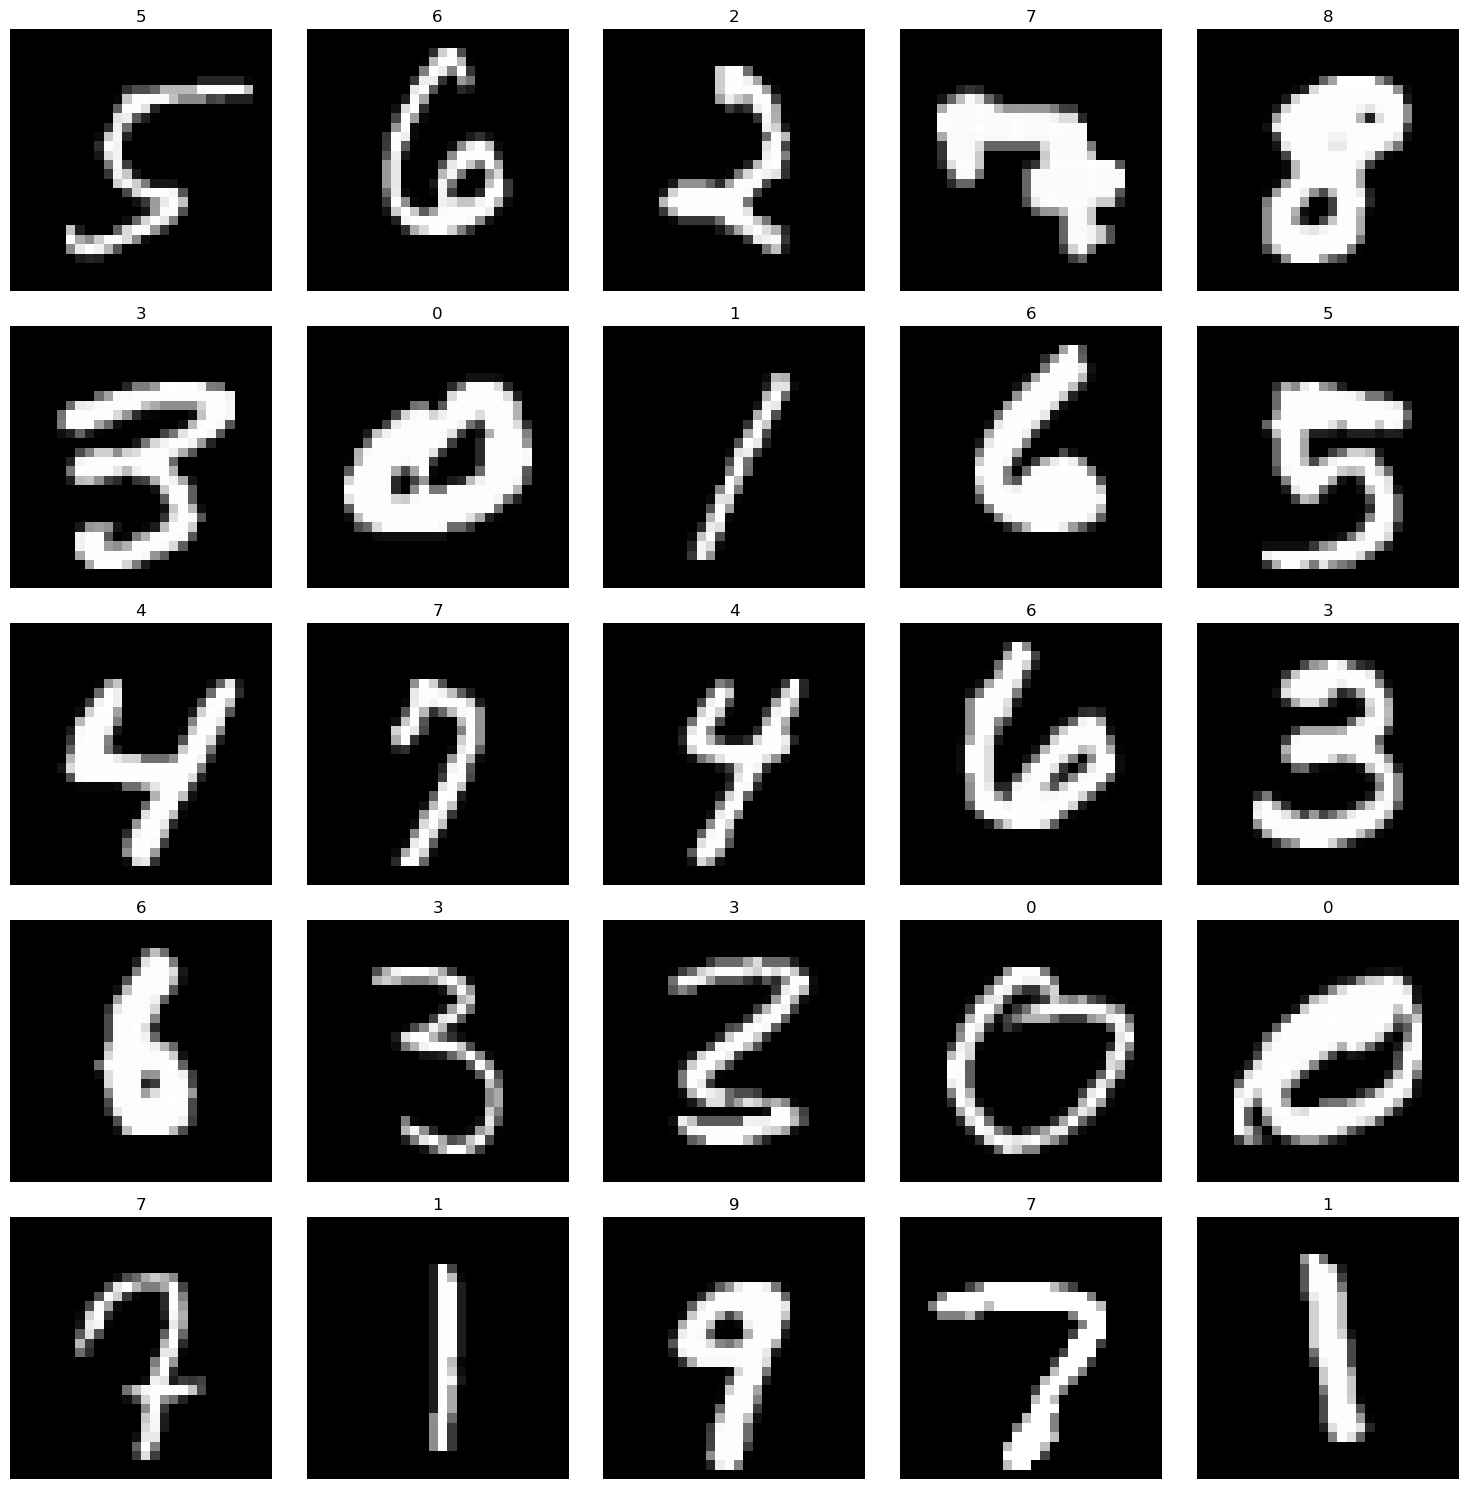

In [17]:
def display_random_image_grid(image_label_pairs):
    """
    Displays a grid of 25 randomly selected images with titles being their respective labels.
    If less than 25 images are provided, it displays all of them.

    :param image_label_pairs: A list of (image, label) tuples.
    """
    # Randomly sample 25 elements from the list (or all if the list is shorter).
    num_samples = min(25, len(image_label_pairs))
    sampled_image_label_pairs = random.sample(image_label_pairs, num_samples)

    # Set the dimensions of the grid.
    num_columns = 5
    num_rows = num_samples // num_columns + int(num_samples % num_columns > 0)

    # Create a figure with subplots in a grid.
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))
    axes = axes.flatten()

    for ax, (image, label) in zip(axes, sampled_image_label_pairs):
        ax.imshow(image.squeeze(0), cmap="gray")  # Display the image.
        ax.set_title(label)  # Set the title to be the label.
        ax.axis("off")  # Hide the axes ticks.

    # Hide any unused subplot areas.
    for ax in axes[num_samples:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


display_random_image_grid(list(train_dataset))

# Vanilla Autoencoder

- Good compression = good learning ( see [Kolmogorov complexity](https://en.wikipedia.org/wiki/Kolmogorov_complexity))
- Can do PCA on latent space, and see trends/dominant factors in the data
- https://www.youtube.com/watch?v=FslFZx08beM


In [151]:
z_dim = 5
encoder = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    # nn.Flatten(),
    # nn.Linear(800, z_dim),
)
encoder(sample_batch).shape

torch.Size([10, 64, 2, 2])

In [135]:
def get_pre_post_flatten_size(model, input_shape):
    with torch.no_grad():
        input = torch.zeros(*input_shape)
        output = model(input)
        # remove output batch dimension(is 1)
        return output.squeeze(0).size(), output.numel()

In [218]:
class AE(L.LightningModule):
    def __init__(self, z_dim=10) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.z_dim = z_dim

        self.c1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.p1 = nn.MaxPool2d(2, return_indices=True)
        self.c2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.p2 = nn.MaxPool2d(2, return_indices=True)
        self.pre_flatten_size, self.post_flatten_size = (64, 2, 2), 256
        self.fc1 = nn.Linear(self.post_flatten_size, z_dim)

        self.fc2 = nn.Linear(z_dim, self.post_flatten_size)
        self.up1 = nn.MaxUnpool2d(2)
        self.uc1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.up2 = nn.MaxUnpool2d(2)
        self.uc2 = nn.ConvTranspose2d(
            32, 1, kernel_size=3, stride=2, padding=1, output_padding=1
        )

    def loss(self, x, decoded):
        epsilon = 1e-8
        decoded = torch.clamp(decoded, epsilon, 1 - epsilon)
        print("Output min:", decoded.min().item(), "Output max:", decoded.max().item())
        # need to have batch seperate
        # return F.mse_loss(x.flatten(1), decoded.flatten(1))
        loss = F.binary_cross_entropy(x.flatten(1), decoded.flatten(1))
        print(loss)
        return loss
        # return F.mse_loss(x, decoded)

    def forward(self, x):
        x = self.c1(x)
        x, idx1 = self.p1(x)
        # print(x.size())
        x = F.relu(x)
        x = self.c2(x)
        x, idx2 = self.p2(x)
        # print(x.size())
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        latent = self.fc1(x)
        # post_flatten_size = x.size(1)
        out = self.fc2(latent)
        out = out.view(out.size(0), *self.pre_flatten_size)
        # print(out.size())
        out = self.up1(out, idx2)
        out = self.uc1(out)
        out = F.relu(out)
        # print(out.size())
        out = self.up2(out, idx1)
        # print(out.size())
        out = self.uc2(out)
        out = F.sigmoid(out)

        return out, latent

    def training_step(self, batch):
        x, _label = batch
        out, _ = self(x)
        loss = self.loss(x, out)
        self.log("Loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch):
        x, _label = batch
        out, _ = self(x)
        loss = self.loss(x, out)
        self.log("Loss/val", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, _label = batch
        out, _ = self(x)
        loss = self.loss(x, out)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [217]:
model = AE()
model(sample_batch)[0].size()

torch.Size([10, 1, 28, 28])

In [219]:
model = AE()


# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         torch.nn.init.xavier_uniform_(m.weight)
#         if m.bias is not None:
#             m.bias.data.fill_(0.01)


# model.apply(weights_init)
logger = TensorBoardLogger("tb_logs", name="autoencoder")
trainer = L.Trainer(max_epochs=10, log_every_n_steps=10, accelerator="cpu")
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type            | Params
-----------------------------------------
0 | c1   | Conv2d          | 320   
1 | p1   | MaxPool2d       | 0     
2 | c2   | Conv2d          | 18.5 K
3 | p2   | MaxPool2d       | 0     
4 | fc1  | Linear          | 2.6 K 
5 | fc2  | Linear          | 2.8 K 
6 | up1  | MaxUnpool2d     | 0     
7 | uc1  | ConvTranspose2d | 18.5 K
8 | up2  | MaxUnpool2d     | 0     
9 | uc2  | ConvTranspose2d | 289   
-----------------------------------------
43.0 K    Trainable params
0         Non-trainable params
43.0 K    Total params
0.172     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Output min: 0.44518738985061646 Output max: 0.5311827659606934
tensor(39.5425)
Output min: 0.4499675929546356 Output max: 0.5292006731033325
tensor(40.2313)


Training: |          | 0/? [00:00<?, ?it/s]

Output min: 0.4447581171989441 Output max: 0.5245946645736694
tensor(39.3217, grad_fn=<BinaryCrossEntropyBackward0>)
Output min: nan Output max: nan


RuntimeError: all elements of target should be between 0 and 1

In [198]:
embs = []
labels = []
for d, label in test_data:
    _, latent = model(d.unsqueeze(0))
    embs.append(latent.detach().numpy().flatten())
    labels.append(label)
embs = np.array(embs)
labels = np.array(labels)

In [199]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 0.742s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.617400
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.209785
[t-SNE] KL divergence after 300 iterations: 3.134444


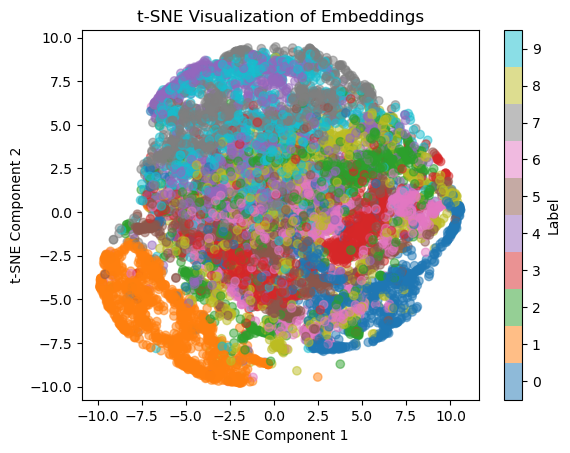

In [201]:
num_classes = len(np.unique(labels))
# Define a colormap with discrete colors
cmap = plt.colormaps["tab10"]

# Create the scatter plot
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, alpha=0.5
)

# Create a colorbar with discrete boundaries
bounds = np.arange(-0.5, len(np.unique(labels)) + 0.5, 1)  # boundaries for each label
norm = plt.Normalize(vmin=min(labels) - 0.5, vmax=max(labels) + 0.5)
cb = plt.colorbar(
    scatter,
    spacing="proportional",
    ticks=np.arange(min(labels), max(labels) + 1),
    boundaries=bounds,
    format="%1i",
    norm=norm,
)
cb.set_label("Label")

# Set plot title and labels
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Variational autoencoder

- The latent space is made to follow a distribution, and that distribution can then be sampled for generative purposes


In [40]:
class VAE(L.LightningModule):
    def __init__(self, z_dim=10) -> None:
        super().__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 10, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 2, 5),
            nn.AdaptiveAvgPool2d(4),  # will be (channels, 4,4) for sure
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2 * 4 * 4, z_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 64),
            nn.ReLU(),
            nn.Unflatten(1, (1, 8, 8)),
            nn.ConvTranspose2d(1, 5, 10),
            nn.ReLU(),
            nn.ConvTranspose2d(5, 1, 12),
            nn.Sigmoid(),
        )
        self.encode_mu = nn.Sequential(
            nn.ReLU(), nn.Linear(z_dim, z_dim), nn.ReLU(), nn.Linear(z_dim, z_dim)
        )

        self.encode_std = nn.Sequential(
            nn.ReLU(), nn.Linear(z_dim, z_dim), nn.ReLU(), nn.Linear(z_dim, z_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        # normally distributed random numbers
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = self.encode_mu(encoded), self.encode_std(encoded)
        latent = self.reparameterize(mu, logvar)
        out = self.decoder(latent)
        return out, mu, logvar, latent

    def vae_loss(self, x, mu, logvar, decoded):
        # MSE = F.mse_loss(x, decoded, reduction="sum")
        BCE = F.binary_cross_entropy(x, decoded)
        # # KL divergence
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    def training_step(self, batch, batch_idx):
        x, _label = batch
        out, mu, logvar, latent = self(x)
        loss = self.vae_loss(x, mu, logvar, out)
        self.log("Loss/train", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _label = batch
        out, mu, logvar, latent = self(x)
        loss = self.vae_loss(x, mu, logvar, out)
        self.log("Loss/val", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [41]:
model = VAE()
logger = TensorBoardLogger("tb_logs", name="variational_autoencoder")
trainer = L.Trainer(max_epochs=20, log_every_n_steps=10)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | Sequential | 1.1 K 
1 | decoder    | Sequential | 1.9 K 
2 | encode_mu  | Sequential | 220   
3 | encode_std | Sequential | 220   
------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/rohan/miniconda3/envs/advent_of_code/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/rohan/miniconda3/envs/advent_of_code/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/Users/rohan/miniconda3/envs/advent_of_code/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [5]:
# model = VAE.load_from_checkpoint(
#     "./lightning_logs/version_2/checkpoints/epoch=19-step=15640.ckpt"
# ).to("cpu")
embs = []
labels = []
for d, label in test_data:
    *_, latent = model(d.unsqueeze(0))
    embs.append(latent.detach().numpy().flatten())
    labels.append(label)
embs = np.array(embs)
labels = np.array(labels)

In [6]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.007s...
[t-SNE] Computed neighbors for 10000 samples in 1.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.860808


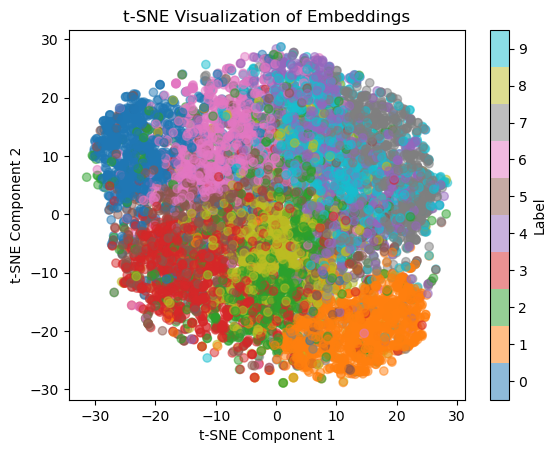

In [ ]:
num_classes = len(np.unique(labels))
# Define a colormap with discrete colors
cmap = plt.colormaps["tab10"]

# Create the scatter plot
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=cmap, alpha=0.5
)

# Create a colorbar with discrete boundaries
bounds = np.arange(-0.5, len(np.unique(labels)) + 0.5, 1)  # boundaries for each label
norm = plt.Normalize(vmin=min(labels) - 0.5, vmax=max(labels) + 0.5)
cb = plt.colorbar(
    scatter,
    spacing="proportional",
    ticks=np.arange(min(labels), max(labels) + 1),
    boundaries=bounds,
    format="%1i",
    norm=norm,
)
cb.set_label("Label")

# Set plot title and labels
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

## Generate new samples by sampling randomly from a normal distribution


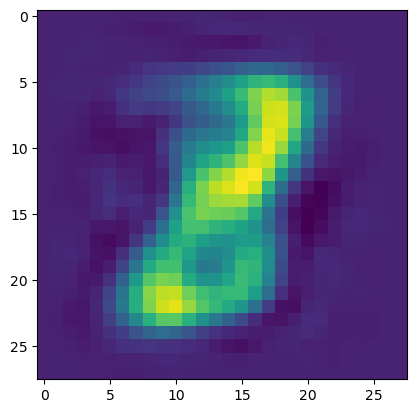

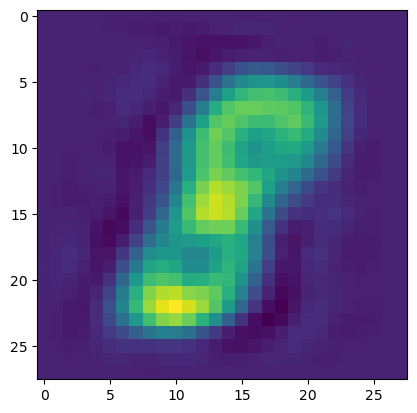

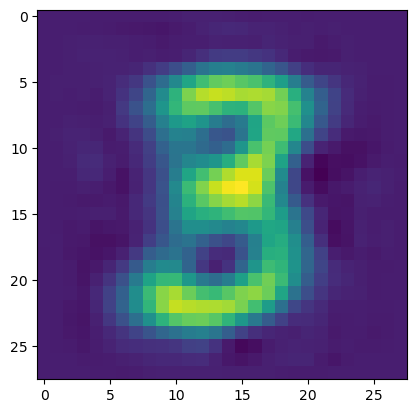

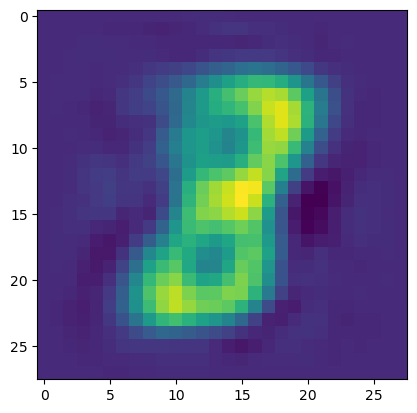

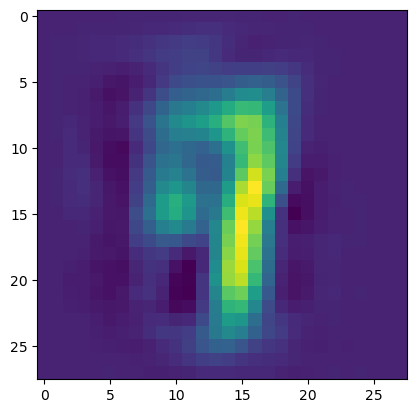

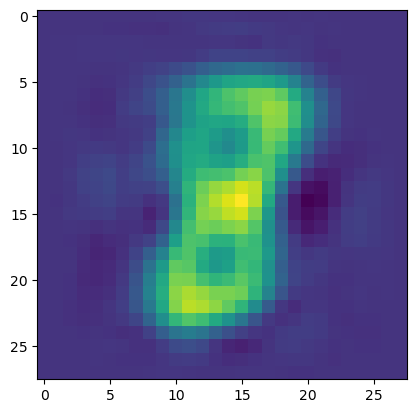

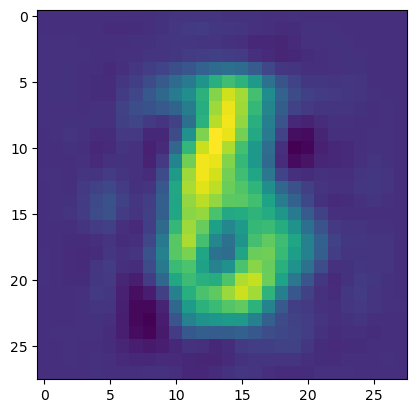

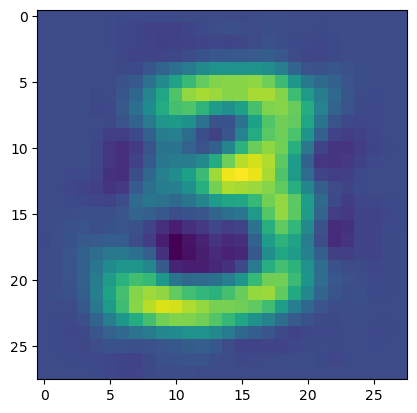

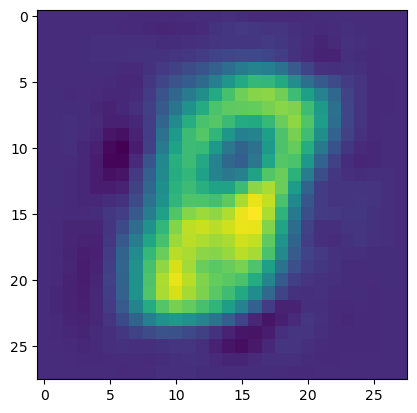

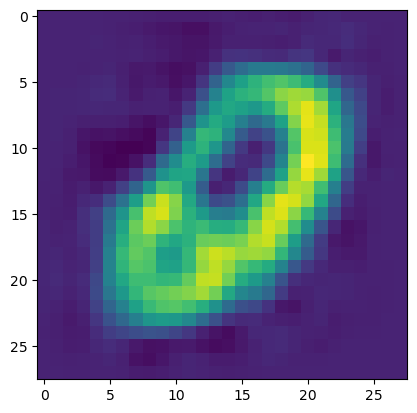

In [16]:
# batchsize, z_size
for out in model.decoder(torch.randn(10, 10)):
    plt.imshow(out.detach().squeeze(0).numpy())
    plt.show()

In [42]:
i1, l1 = train_dataset[0]
i2, l2 = train_dataset[20]
o1, *_, e1 = model(i1.unsqueeze(0))
o2, *_, e2 = model(i2.unsqueeze(0))
i1 = i1.squeeze(0)
i2 = i2.squeeze(0)
o1 = o1.detach().numpy().squeeze(0).squeeze(0)
o2 = o2.detach().numpy().squeeze(0).squeeze(0)

l1, l2

(1, 5)

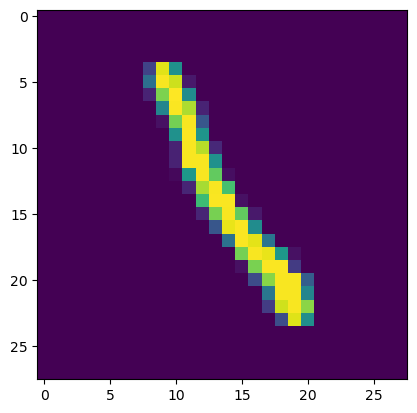

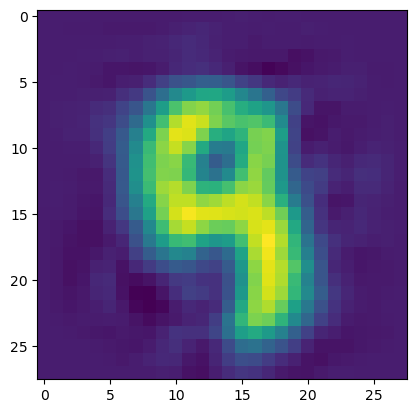

In [45]:
plt.imshow(i1)
plt.show()
plt.imshow(o1)
plt.show()

In [34]:
def interpolate(v1, v2, t):
    """
    Linearly interpolate between two vectors.

    Parameters:
        v1 (np.array): The first vector.
        v2 (np.array): The second vector.
        t (float): The interpolation factor (0 <= t <= 1).

    Returns:
        np.array: The interpolated vector.
    """
    return (1 - t) * v1 + t * v2


ts = np.linspace(0, 1, num=10)  # 10 points from 0 to 1
interpolated_embeddings = [interpolate(e1, e2, t) for t in ts]
interpolated_imgs = [
    model.decoder(e).squeeze(0).squeeze(0).detach().numpy()
    for e in interpolated_embeddings
]

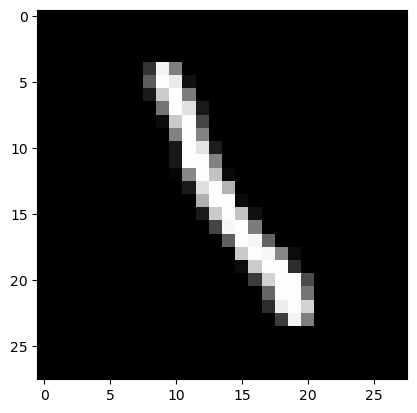

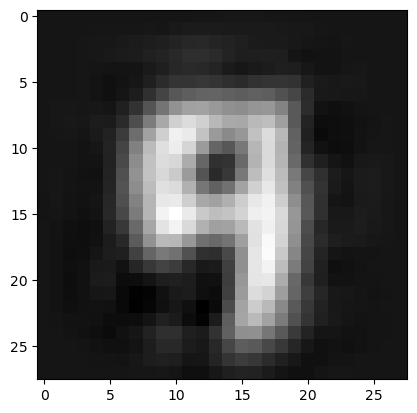

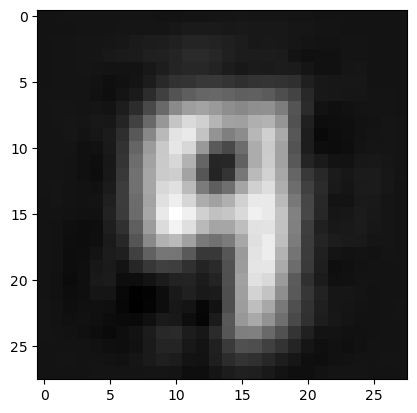

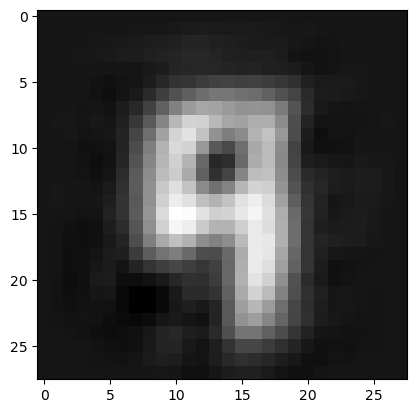

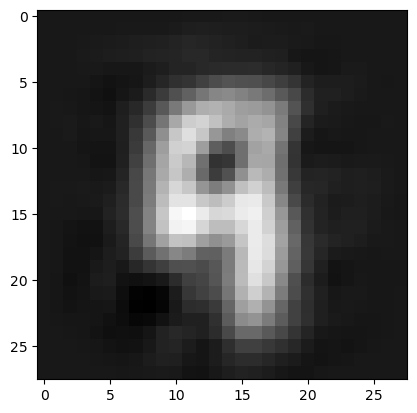

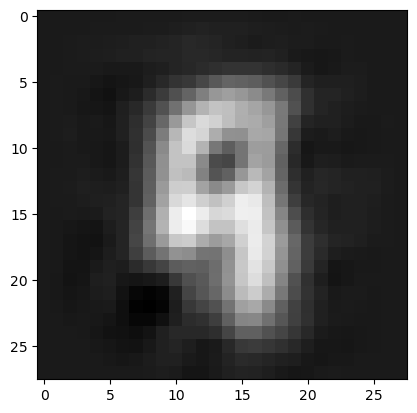

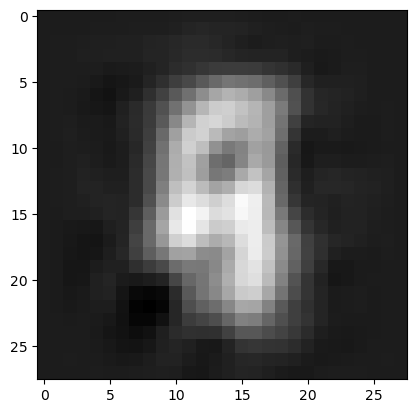

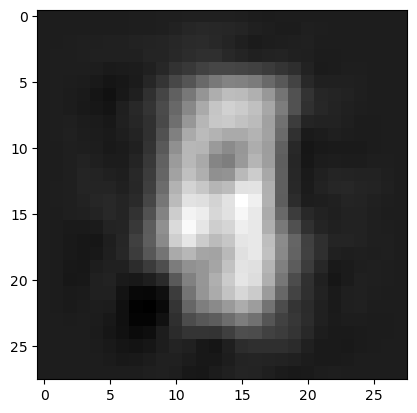

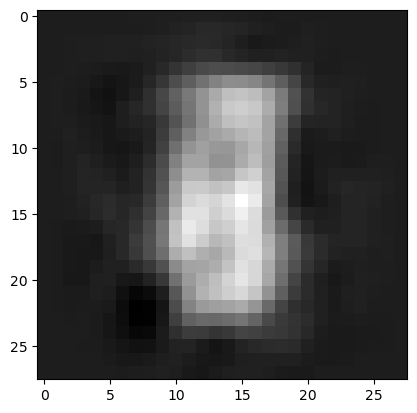

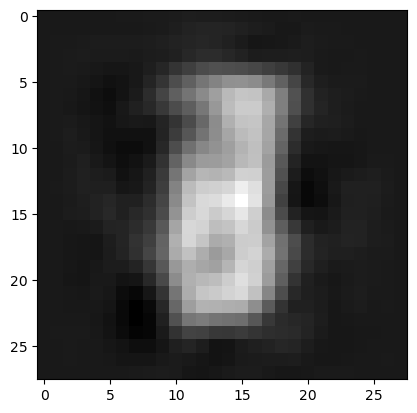

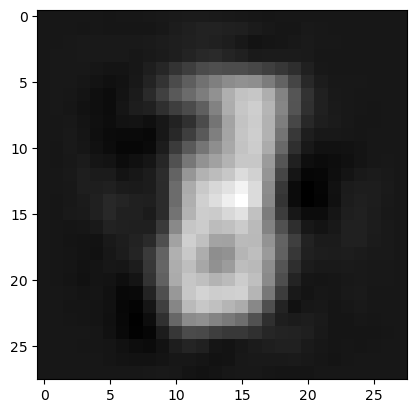

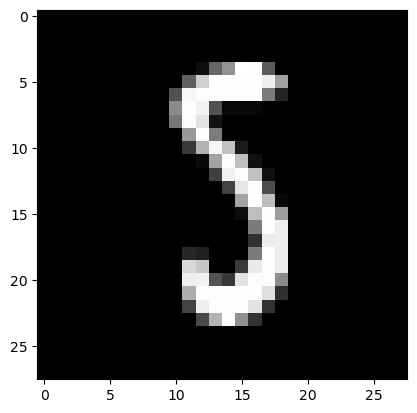

In [35]:
plt.imshow(i1.squeeze(0), cmap="gray")
plt.show()
for im in interpolated_imgs:
    plt.imshow(im, cmap="gray")
    plt.show()
plt.imshow(i2.squeeze(0), cmap="gray")